# Network Analysis on Karate Club Data

Let us load the modules that we use for this analysis

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from itertools import groupby
import random
from tqdm import tqdm

UF Sparse Matrix Collection, Tim Davis
http://www.cise.ufl.edu/research/sparse/matrices/Newman/karate
name: Newman/karate
[Karate club, from Wayne Zachary, 1977]
id: 2399
date: 1977
author: W. Zachary
ed: M. Newman
fields: name title A id date author kind notes ed
kind: undirected graph                             


notes:
Network collection from M. Newman                                          
http://www-personal.umich.edu/~mejn/netdata/                               
                                                                           
The graph "karate" contains the network of friendships between the 34      
members of a karate club at a US university, as described by Wayne Zachary 
in 1977.  If you use these data in your work, please cite W. W. Zachary, An
information flow model for conflict and fission in small groups, Journal of
Anthropological Research 33, 452-473 (1977).  

Reading the node and edge files

In [2]:
edges = pd.read_csv('data/soc-karate.csv')

In [3]:
edges.shape

(78, 2)

In [4]:
edges.head()

,From,To
0,2,1
1,3,1
2,4,1
3,5,1
4,6,1


In [5]:
edges.dtypes

From    int64
To      int64
dtype: object

Create a grpah object from the edge list

In [6]:
snfb = nx.from_pandas_edgelist(df=edges, source='From', target='To')

In [7]:
# Quick Snapshot of the network
print(nx.info(snfb))

Name: 
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


Visualizing Graph might take some time

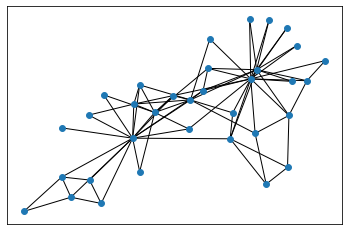

In [8]:
nx.draw_networkx(snfb, pos=nx.spring_layout(snfb), with_labels=False, node_size=35)

As we can see, there are lot small subgraphs in this network. Let us just focus on teh largest connected component

In [9]:
[len(c) for c in sorted(nx.connected_components(snfb), key=len, reverse=True)]

[34]

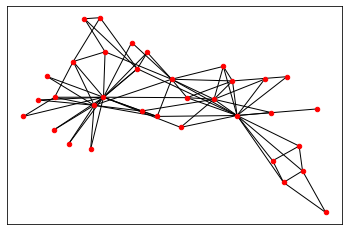

In [10]:
nx.draw_networkx(snfb, pos=nx.spring_layout(snfb), with_labels=False, node_size=20, node_color='r')

Extract local node features for all the nodes present in largest connected graph

In [11]:
g_features = pd.DataFrame({'Degree':nx.degree_centrality(snfb),
                           'Closeness':nx.closeness_centrality(snfb),
                           'Betweenness':nx.betweenness_centrality(snfb),
                           'Eigenvector':nx.eigenvector_centrality_numpy(snfb),
                           'Katz':nx.katz_centrality_numpy(snfb),
                           'PageRank':nx.pagerank(snfb),
                           'GlobalReaching':nx.global_reaching_centrality(snfb)
})

In [12]:
g_features.head()

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching
2,0.272727,0.485294,0.053937,0.265960,0.235484,0.052878,0.218978
1,0.484848,0.568966,0.437635,0.355491,0.321325,0.097002,0.218978
3,0.303030,0.559322,0.143657,0.317193,0.265766,0.057078,0.218978
4,0.181818,0.464789,0.011909,0.211180,0.194913,0.035861,0.218978
5,0.090909,0.379310,0.000631,0.075969,0.121904,0.021979,0.218978


Let us look at the correlations between these local graph metrics

In [13]:
corr = g_features.corr()
corr.style.background_gradient(cmap='RdYlGn').set_precision(2)

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching
Degree,1.00,0.77,0.91,0.92,0.97,1.00,0.00
Closeness,0.77,1.00,0.72,0.90,0.88,0.74,-0.00
Betweenness,0.91,0.72,1.00,0.80,0.87,0.92,0.00
Eigenvector,0.92,0.90,0.80,1.00,0.99,0.89,-0.00
Katz,0.97,0.88,0.87,0.99,1.00,0.95,0.00
PageRank,1.00,0.74,0.92,0.89,0.95,1.00,0.00
GlobalReaching,0.00,-0.00,0.00,-0.00,0.00,0.00,1.00


We will apply an anomaly detection technique called IsolationForest to identify anomalous communication behavior based on local graph metrics

In [14]:
from sklearn.ensemble import IsolationForest
isof = IsolationForest(n_estimators=1000, max_samples='auto', contamination=0.1, 
                      max_features=1.0, bootstrap=False, n_jobs=-1,
                      random_state=2020, verbose=1, behaviour='new')
isof.fit(g_features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.9s remaining:    1.8s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.9s finished


IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=1000,
                n_jobs=-1, random_state=2020, verbose=1, warm_start=False)

In [15]:
anomaly_score = isof.decision_function(g_features)
anomaly_score_new = np.interp(anomaly_score, (np.min(anomaly_score), np.max(anomaly_score)), (0,1))

In [16]:
g_features['anomaly_score_new'] = anomaly_score_new

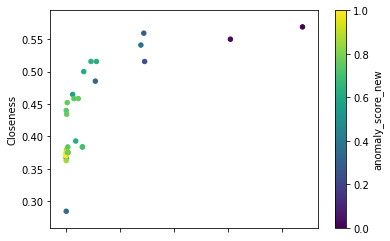

In [17]:
g_features.plot.scatter(x='Betweenness',
                       y='Closeness',
                       c='anomaly_score_new',
                       colormap='viridis')

From the above scatter plot, we cann see all teh darker points are anomalies based on Betweenness Centrality and Closeness Centrality

In [18]:
g_features = g_features.sort_values(by='anomaly_score_new', ascending=True)

In [33]:
import gc
gc.collect()

7187

In [20]:
color_map = []
for node in snfb:
    if node in g_features.index[0:5]:
        color_map.append('red')
    else: color_map.append('green')

In [21]:
size_map = []
for node in snfb:
    if node in g_features.index[0:5]:
        size_map.append(200)
    else: size_map.append(100) 
    

Top 10 anomalies absed on all the local metrics that we calculated

In [22]:
g_features.head(10)

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching,anomaly_score_new
1,0.484848,0.568966,0.437635,0.355491,0.321325,0.097002,0.218978,0.000000
34,0.515152,0.550000,0.304075,0.373363,0.331406,0.100918,0.218978,0.022608
33,0.363636,0.515625,0.145247,0.308644,0.275085,0.071692,0.218978,0.248905
3,0.303030,0.559322,0.143657,0.317193,0.265766,0.057078,0.218978,0.293827
2,0.272727,0.485294,0.053937,0.265960,0.235484,0.052878,0.218978,0.329154
17,0.060606,0.284483,0.000000,0.023636,0.090679,0.016785,0.218978,0.346488
32,0.181818,0.540984,0.138276,0.191034,0.193802,0.037157,0.218978,0.375547
12,0.030303,0.366667,0.000000,0.052856,0.096617,0.009565,0.218978,0.455918
4,0.181818,0.464789,0.011909,0.211180,0.194913,0.035861,0.218978,0.563782
20,0.090909,0.500000,0.032475,0.147913,0.153306,0.019604,0.218978,0.604606


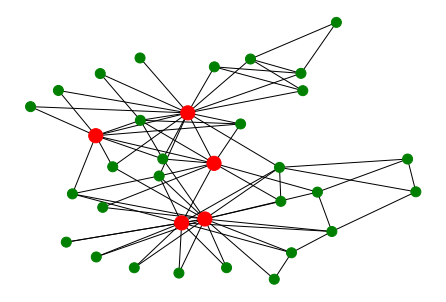

In [23]:
pos=nx.kamada_kawai_layout(snfb)
nx.draw(snfb, node_color = color_map, node_size=size_map, pos = pos, with_labels = False)

Let us detect communities based on the similar patterns in emails

In [24]:
from community import community_louvain
parts = community_louvain.best_partition(snfb)
values = [parts.get(node) for node in snfb.nodes()]

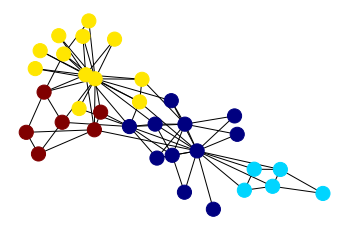

In [25]:
plt.axis("off")
spring_pos=nx.spring_layout(snfb)
nx.draw_networkx(snfb, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 200, with_labels = False)

In [26]:
same_neighbors = lambda u, v: (u not in snfb[v] and v not in snfb[u] and snfb[u] == snfb[v])
qsnfb = nx.quotient_graph(snfb, same_neighbors)

In [27]:
print(nx.info(qsnfb))

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 68
Average degree:   4.6897


In [28]:
from community import community_louvain
parts = community_louvain.best_partition(qsnfb)
values = [parts.get(node) for node in qsnfb.nodes()]

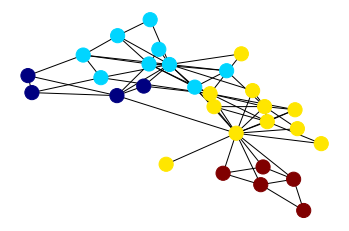

In [29]:
plt.axis("off")
spring_pos=nx.spring_layout(qsnfb)
nx.draw_networkx(qsnfb, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 200, with_labels = False)

In [30]:
from pyvis.network import Network
net = Network("1000px", "1000px", notebook=True)

In [31]:
net.from_nx(snfb)
net.show_buttons(filter_=['physics'])

In [32]:
net.show('karate.html')